In [2]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import pandas as pd
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, cohen_kappa_score, ConfusionMatrixDisplay

pd.set_option('display.max_colwidth', None)
seed = 2024
filename = 'Prudential_Life_Insurance_train.csv'
%matplotlib inline
np.random.seed(seed)

<span style="font-size: 20px;">Data Acquisition</span>

In [2]:
df = pd.read_csv(filename)
display(df.head(10))
df.drop(columns='Id', inplace=True)

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,...,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,...,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,...,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,...,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,...,0,0,0,0,0,0,0,0,0,8
5,10,1,D2,26,0.230769,3,1,1,0.507463,0.836364,...,0,0,0,0,0,0,0,0,0,8
6,11,1,A8,10,0.166194,2,3,1,0.373134,0.581818,...,0,0,0,0,0,0,0,0,0,8
7,14,1,D2,26,0.076923,2,3,1,0.611940,0.781818,...,0,0,0,0,0,0,0,0,0,1
8,15,1,D3,26,0.230769,2,3,1,0.522388,0.618182,...,0,0,0,0,0,0,0,0,0,8
9,16,1,E1,21,0.076923,2,3,1,0.552239,0.600000,...,0,0,0,0,0,0,0,0,0,1


After dropping the 'Id' column, the next necessary step is addressing the null values, as seen in the Data Visualization notebook. 

<span style="font-size: 20px;">Data Cleaning</span>

In [3]:
null_c = df.isnull().sum().sort_values(ascending = False)
null_c = null_c[null_c > 0 ]


null_c_toremove = null_c[null_c > df.shape[0] * 0.7].index
df.drop(columns = null_c_toremove, inplace=True)

null_c.drop(null_c_toremove, inplace=True)
print('Column with null values: ', null_c.index)

Column with null values:  Index(['Family_Hist_3', 'Family_Hist_2', 'Insurance_History_5',
       'Family_Hist_4', 'Employment_Info_6', 'Medical_History_1',
       'Employment_Info_4', 'Employment_Info_1'],
      dtype='object')


The strategy adopted is to drop all the columns that have at least 70% of nulls. For the remaining ones, listed above, the values will be imputed.

The next step is splitting the data in train, validation and test set. The chosen percentage is: 68% for train, 12% for validation, 20% for test. PredefinedSplit is used in the GridSearch object for the hyperparameter search. 

<span style="font-size: 20px;">Data Splitting</span>

In [4]:
train, test = train_test_split(df, test_size= 0.2, stratify=df['Response'], random_state=seed)
train, validation = train_test_split(train, test_size= 0.15, stratify=train['Response'], random_state=seed)

print('Number of samples in train: ', train.shape[0])
print('Number of samples in validation: ', validation.shape[0])
print('Number of samples in test: ', test.shape[0])

Number of samples in train:  40378
Number of samples in validation:  7126
Number of samples in test:  11877


In [5]:
target = 'Response'
X_train = train.drop(target, axis = 1)
X_validation = validation.drop(target, axis = 1)
X_test = test.drop(target, axis = 1)

y_train = train[target]
y_validation = validation[target]
y_test = test[target]

split_index = [-1]*len(X_train) + [0]*len(X_validation)
ps = PredefinedSplit(test_fold = split_index)

X_train_val = pd.concat((X_train, X_validation))
y_train_val = pd.concat((y_train, y_validation))

The following two cells contains the objects used in the preprocessing step. First, the features are splitted in categorical, discrete and continuous; then, three different Pipelines object are created to process diffent data in a sequential way, and then used together as transformers in a ColumnTransformer object to process the columns in parallel.   

<span style="font-size: 20px;">Preprocessing Steps</span>

In [6]:
categorical_features= []
cat_col_reduction = ['Medical_History_2'] #this categorical feature will be reduced with SelectKBest as it has more than 200 different categories
discrete_features = ['Medical_History_1']
continuous_features = []

for c in df.columns:
    if df[c].dtype == 'int64' or df[c].dtype == 'object':
        categorical_features.append(c)
    if df[c].dtype == 'float64':
        continuous_features.append(c)

continuous_features = [f for f in continuous_features if f not in discrete_features]
categorical_features = [f for f in categorical_features if f not in cat_col_reduction]
categorical_features = categorical_features[:-1]

Only continuous and discrete features contains nulls, so the first step of both pipelines is a SimpleImputer object, with a constant value for discrete variables (-1), and the mean of the remaining values for the continuous ones. Then, a PowerTransformer is used to make the features distribution Gaussian, to reduce skewness. All the categorical features were encoded with a OneHotEncoder.

In [7]:
discrete_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy = 'constant', fill_value= -1)),
                                    ('scaler', PowerTransformer())])
continuous_pipeline = Pipeline(steps=[('imputer', SimpleImputer()),
                                    ('scaler', PowerTransformer())])
cat_reduction_pipeline = Pipeline(steps= [('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
                                          ('reduction', SelectKBest(f_classif, k= 20))
                                          ])


col_transformer = ('col_transformer', ColumnTransformer(transformers = [
                                    ('continuous', continuous_pipeline, continuous_features),
                                    ('discrete', discrete_pipeline, discrete_features),
                                    ('cat_low_cardinality', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
                                    ('cat_high_cardinality', cat_reduction_pipeline, cat_col_reduction)
                                    ]))

#definition of additional preprocessing steps: pca, lda, nystroem
pca = ('pca', PCA(n_components=0.95, random_state=seed))
lda = ('lda', LinearDiscriminantAnalysis())
nystroem = ('nystroem', Nystroem(n_jobs=-1,random_state=seed))
#scoring function: quatratic weighted kappa 
scorer = make_scorer(cohen_kappa_score, weights= 'quadratic')

models_results = pd.DataFrame(columns=['Model', 'Preprocessing steps', 'Estimator', 'Kappa']) #dataframe to store modeling results 

<span style="font-size: 25px;">Modeling</span>

The next step is the modeling one: for every model, a GridSerch object was istantiated to search for the best hyperparameters with different preprocessing steps. The results are listed in a table for every model, and than displayed with a ConfusionMatrixDisplay.  

<span style="font-size: 20px;">Logistic Regression</span>

<span style="font-size: 17px;">Kappa: 0.505</span>

In [10]:
lr_results= pd.DataFrame(columns=['Preprocessor','Kappa','Params'])
best_kappa= -np.inf
best_preproc= None


classifier = ('estimator', LogisticRegression())

param_grid = {'estimator__C' : [1],#0.1, 0.01, 0.001
              'estimator__class_weight': ['balanced'],
              'estimator__solver': ['newton-cg'],#'lbfgs', 
              'estimator__n_jobs': [-1]
              }

preproc = ['none', 'pca', 'lda']

for prep in preproc:
    steps = [col_transformer]
   
    if prep == 'none':
        steps.append(('passthrough', 'passthrough'))
    if prep == 'pca':
        steps.append(pca)
    if prep == 'lda':
        steps.append(lda)
    
    steps.append(classifier)

    pipeline = Pipeline(steps)

    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring= scorer, cv=ps)
    grid.fit(X_train_val, y_train_val)
    log_regr_pred=grid.predict(X_test)
    
    score = cohen_kappa_score(y_test, log_regr_pred, weights= 'quadratic')
    lr_results.loc[len(lr_results)]= [prep,score,grid.best_params_]
    
    if score > best_kappa:
        best_kappa= score
        best_preproc= grid.best_estimator_
        best_params= grid.best_params_

models_results.loc[len(models_results)]= ['LogisticRegression', best_preproc[:-1], best_preproc[-1], best_kappa]

In [10]:
lr_results.sort_values(by= 'Kappa',ascending=False)

,Preprocessor,Kappa,Params
0,none,0.505849,"{'estimator__C': 1, 'estimator__class_weight': 'balanced', 'estimator__n_jobs': -1, 'estimator__solver': 'newton-cg'}"
2,lda,0.505426,"{'estimator__C': 1, 'estimator__class_weight': 'balanced', 'estimator__n_jobs': -1, 'estimator__solver': 'lbfgs'}"
1,pca,0.462529,"{'estimator__C': 0.1, 'estimator__class_weight': 'balanced', 'estimator__n_jobs': -1, 'estimator__solver': 'newton-cg'}"


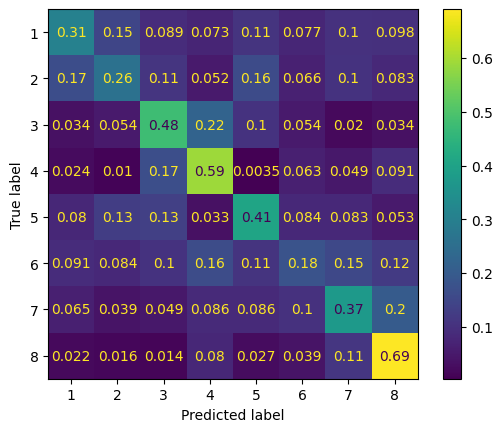

In [11]:
log_regr_pred = best_preproc.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, log_regr_pred, normalize = 'true', cmap = 'viridis')

<span style="font-size: 20px;">LinearSVC</span>

<span style="font-size: 17px;">Kappa: 0.495</span>

In [13]:
svc_results= pd.DataFrame(columns=['Preprocessor','Kappa','Params'])
best_kappa= -np.inf
best_preproc= None

estimator = ('estimator', LinearSVC())

param_grid = {'estimator__class_weight' : ['balanced'],
              'estimator__C':[0.01],  #0.1, 
              'estimator__max_iter': [10000],
              'estimator__dual':['auto'],
              'nystroem__n_components' : [200],#100
              'nystroem__kernel' : ['poly'],#, 'rbf'
              'nystroem__gamma': [0.1],#1
              'nystroem__degree': [3]#2, 
              }

preproc = ['none', 'pca', 'lda']

for prep in preproc:
    
    steps = [col_transformer]
    
    steps.append(nystroem)
    
    if prep == 'none':
        steps.append(('passthrough', 'passthrough'))
    if prep == 'pca':
        steps.append(pca)
    if prep == 'lda':
        steps.append(lda)
    steps.append(estimator)
    pipeline = Pipeline(steps)

    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring= scorer, cv=ps)
    grid.fit(X_train_val, y_train_val)
    svc_pred=grid.predict(X_test)
  
    score = cohen_kappa_score(y_test, svc_pred, weights= 'quadratic')
    svc_results.loc[len(svc_results)]= [prep,score,grid.best_params_]
    
    if score > best_kappa:
        best_kappa= score
        best_preproc= grid.best_estimator_
        best_params= grid.best_params_

models_results.loc[len(models_results)]= ['LinearSVR', best_preproc[:-1], best_preproc[-1], best_kappa]

In [13]:
svc_results.sort_values(by = 'Kappa', ascending = False)

,Preprocessor,Kappa,Params
0,none,0.495453,"{'estimator__C': 0.01, 'estimator__class_weight': 'balanced', 'estimator__dual': 'auto', 'estimator__max_iter': 10000, 'nystroem__degree': 3, 'nystroem__gamma': 0.1, 'nystroem__kernel': 'poly', 'nystroem__n_components': 200}"
2,lda,0.495025,"{'estimator__C': 0.1, 'estimator__class_weight': 'balanced', 'estimator__dual': 'auto', 'estimator__max_iter': 10000, 'nystroem__degree': 3, 'nystroem__gamma': 0.1, 'nystroem__kernel': 'poly', 'nystroem__n_components': 200}"
1,pca,0.470472,"{'estimator__C': 0.1, 'estimator__class_weight': 'balanced', 'estimator__dual': 'auto', 'estimator__max_iter': 10000, 'nystroem__degree': 3, 'nystroem__gamma': 1, 'nystroem__kernel': 'poly', 'nystroem__n_components': 200}"


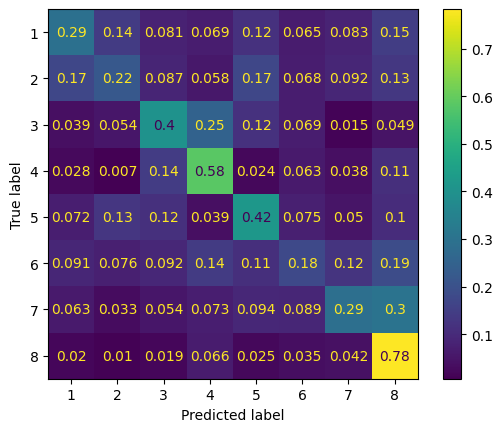

In [15]:
svc_pred = best_preproc.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, svc_pred, normalize = 'true', cmap = 'viridis')

<span style="font-size: 20px;">KNeighborsClassifier</span>

<span style="font-size: 17px;">Kappa: 0.515</span>

In [16]:
knc_results= pd.DataFrame(columns=['Preprocessor','Kappa','Params'])
best_kappa= -np.inf
best_preproc= None


estimator = ('estimator', KNeighborsClassifier())


param_grid = {'estimator__n_neighbors' : [25],#, 30
              'estimator__weights':['uniform'],#, 'distance'
              'estimator__p': [1],#, 2
              'estimator__n_jobs' : [-1],
              'estimator__leaf_size' : [20]#, 30
              }

preproc = ['none', 'pca', 'lda']

for prep in preproc:
    
    steps = [col_transformer]
    
    if prep == 'none':
        steps.append(('passthrough', 'passthrough'))
    if prep == 'pca':
        steps.append(pca)
    if prep == 'lda':
        steps.append(lda)
    steps.append(estimator)
    pipeline = Pipeline(steps)

    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring= scorer, cv=ps)
    grid.fit(X_train_val, y_train_val)
    knc_pred=grid.predict(X_test)
  
    score = cohen_kappa_score(y_test, knc_pred, weights= 'quadratic')
    knc_results.loc[len(knc_results)]= [prep,score,grid.best_params_]
    
    if score > best_kappa:
        best_kappa= score
        best_preproc= grid.best_estimator_
        best_params= grid.best_params_

models_results.loc[len(models_results)]= ['KNeighborsClassifier', best_preproc[:-1], best_preproc[-1], best_kappa]

In [16]:
knc_results.sort_values(by = 'Kappa', ascending = False)

,Preprocessor,Kappa,Params
2,lda,0.515597,"{'estimator__leaf_size': 20, 'estimator__n_jobs': -1, 'estimator__n_neighbors': 25, 'estimator__p': 1, 'estimator__weights': 'uniform'}"
1,pca,0.348579,"{'estimator__leaf_size': 20, 'estimator__n_jobs': -1, 'estimator__n_neighbors': 25, 'estimator__p': 2, 'estimator__weights': 'uniform'}"
0,none,0.329547,"{'estimator__leaf_size': 20, 'estimator__n_jobs': -1, 'estimator__n_neighbors': 25, 'estimator__p': 2, 'estimator__weights': 'uniform'}"


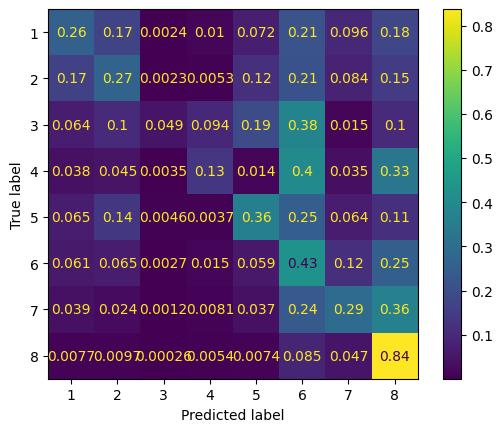

In [18]:
knc_pred = best_preproc.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, knc_pred, normalize = 'true', cmap = 'viridis')

After the supervised traditional techniques, more complex models were instantiated, trying to obtain a better performance.   

<span style="font-size: 20px;">MLPClassifier</span>

<span style="font-size: 17px;">Kappa: 0.533</span>

In [19]:
nn_results= pd.DataFrame(columns=['Preprocessor','Kappa','Params'])
best_kappa= -np.inf
best_preproc= None

estimator = ('estimator', MLPClassifier())


param_grid = {'estimator__hidden_layer_sizes' : [(256,256)],#(128,128)
              'estimator__learning_rate_init':[0.001],#, 0.01
              'estimator__learning_rate': ['adaptive'],
              'estimator__activation': ['relu'],
              'estimator__solver': ['adam', 'sgd'],
              'estimator__alpha' : [0.0001],
              'estimator__max_iter': [400],
              'estimator__batch_size' : [256],#, 512
              'estimator__random_state' : [seed],
              'estimator__warm_start' : [True],
              'estimator__early_stopping': [True],
              'estimator__n_iter_no_change': [30],#20,
              }

preproc = ['none', 'pca', 'lda']#'none', 'pca', 

for prep in preproc:
    
    steps = [col_transformer]
    
    if prep == 'none':
        steps.append(('passthrough', 'passthrough'))
    if prep == 'pca':
        steps.append(pca)
    if prep == 'lda':
        steps.append(lda)
    steps.append(estimator)
    pipeline = Pipeline(steps)

    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring= scorer, cv = ps)
    grid.fit(X_train_val, y_train_val)
    nn_pred=grid.predict(X_test)
  
    score = cohen_kappa_score(y_test, nn_pred, weights= 'quadratic')
    nn_results.loc[len(nn_results)]= [prep,score,grid.best_params_]
    
    if score > best_kappa:
        best_kappa= score
        best_preproc= grid.best_estimator_
        best_params= grid.best_params_
        
models_results.loc[len(models_results)]= ['MLPClassifier', best_preproc[:-1], best_preproc[-1], best_kappa]

In [13]:
nn_results.sort_values(by = 'Kappa', ascending = False)

,Preprocessor,Kappa,Params
0,none,0.533620,"{'estimator__activation': 'relu', 'estimator__alpha': 0.0001, 'estimator__batch_size': 256, 'estimator__early_stopping': True, 'estimator__hidden_layer_sizes': (256, 256), 'estimator__learning_rate': 'adaptive', 'estimator__learning_rate_init': 0.001, 'estimator__max_iter': 400, 'estimator__n_iter_no_change': 30, 'estimator__random_state': 2024, 'estimator__solver': 'adam', 'estimator__warm_start': True}"
2,lda,0.522201,"{'estimator__activation': 'relu', 'estimator__alpha': 0.0001, 'estimator__batch_size': 256, 'estimator__early_stopping': True, 'estimator__hidden_layer_sizes': (256, 256), 'estimator__learning_rate': 'adaptive', 'estimator__learning_rate_init': 0.001, 'estimator__max_iter': 400, 'estimator__n_iter_no_change': 30, 'estimator__random_state': 2024, 'estimator__solver': 'adam', 'estimator__warm_start': True}"
1,pca,0.513553,"{'estimator__activation': 'relu', 'estimator__alpha': 0.0001, 'estimator__batch_size': 256, 'estimator__early_stopping': True, 'estimator__hidden_layer_sizes': (256, 256), 'estimator__learning_rate': 'adaptive', 'estimator__learning_rate_init': 0.001, 'estimator__max_iter': 400, 'estimator__n_iter_no_change': 30, 'estimator__random_state': 2024, 'estimator__solver': 'adam', 'estimator__warm_start': True}"


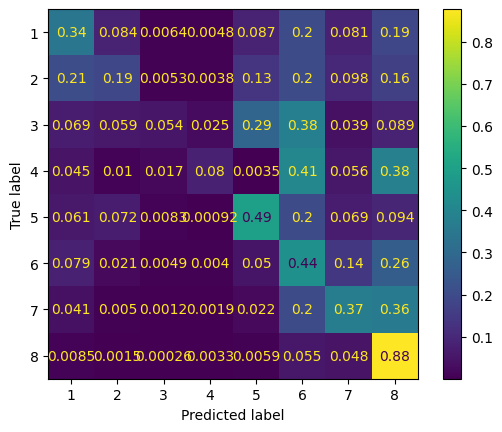

In [21]:
nn_pred = best_preproc.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, nn_pred, normalize = 'true', cmap = 'viridis')

For the following models, the whole preprocessing pipeline was not implemented. This is because the models are capable to handle null values and categorical features directly, that may yield better performance compared to methods that rely on imputation or removal of nan, which can lead to loss of information.

<span style="font-size: 20px;">HistGradientBoostingClassifier</span>

<span style="font-size: 17px;">Kappa: 0.563</span>

In [3]:
df_w_nan = pd.read_csv(filename)
display(df_w_nan.head(10))
df_w_nan.drop(columns='Id', inplace=True)

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,...,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,...,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,...,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,...,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,...,0,0,0,0,0,0,0,0,0,8
5,10,1,D2,26,0.230769,3,1,1,0.507463,0.836364,...,0,0,0,0,0,0,0,0,0,8
6,11,1,A8,10,0.166194,2,3,1,0.373134,0.581818,...,0,0,0,0,0,0,0,0,0,8
7,14,1,D2,26,0.076923,2,3,1,0.611940,0.781818,...,0,0,0,0,0,0,0,0,0,1
8,15,1,D3,26,0.230769,2,3,1,0.522388,0.618182,...,0,0,0,0,0,0,0,0,0,8
9,16,1,E1,21,0.076923,2,3,1,0.552239,0.600000,...,0,0,0,0,0,0,0,0,0,1


In [4]:
df_w_nan['Medical_History_2'] = df_w_nan['Medical_History_2'].astype('float64') # the data type is changed because this var has > 500 categories, when the limit for the model is 255

for c in df_w_nan.columns[:-1]:
    if df_w_nan[c].dtype == 'int64' or df_w_nan[c].dtype == 'object':
        df_w_nan[c] = df_w_nan[c].astype('category') #setting the 'category' data type helps the model to understand which are the categorical vars

In [5]:
train, test = train_test_split(df_w_nan, test_size= 0.2, stratify=df_w_nan['Response'], random_state=seed)
train, validation = train_test_split(train, test_size= 0.15, stratify=train['Response'], random_state=seed)

print('Number of samples in train: ', train.shape[0])
print('Number of samples in validation: ', validation.shape[0])
print('Number of samples in test: ', test.shape[0])

Number of samples in train:  40378
Number of samples in validation:  7126
Number of samples in test:  11877


In [26]:
target = 'Response'
X_train = train.drop(target, axis = 1)
X_validation = validation.drop(target, axis = 1)
X_test = test.drop(target, axis = 1)

y_train = train[target]
y_validation = validation[target]
y_test = test[target]

split_index = [-1]*len(X_train) + [0]*len(X_validation)
ps = PredefinedSplit(test_fold = split_index)

X_train_val = pd.concat((X_train, X_validation))
y_train_val = pd.concat((y_train, y_validation))

In [27]:
hgb_results= pd.DataFrame(columns=['Preprocessor','Kappa','Params'])

estimator = HistGradientBoostingClassifier(categorical_features = 'from_dtype')

param_grid = {'class_weight' : ['balanced'],
              'learning_rate':[0.1, 0.01],
              'max_depth': [15, 20],
              'l2_regularization': [0.1, 0.01],
              'max_leaf_nodes': [20],
              'random_state': [seed],
              'n_iter_no_change': [20],
              'validation_fraction': [None],
              'scoring': [scorer]}

grid = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring= scorer, cv=ps)
grid.fit(X_train_val, y_train_val)
hgb_pred=grid.predict(X_test)
    
  
score = cohen_kappa_score(y_test, hgb_pred, weights= 'quadratic')
hgb_results.loc[len(hgb_results)]= ['none',score,grid.best_params_]
models_results.loc[len(models_results)]= ['HistGradientBoostingClassifier', 'none', estimator, score]

In [28]:
hgb_results.sort_values(by = 'Kappa', ascending= False)

,Preprocessor,Kappa,Params
0,none,0.563959,"{'class_weight': 'balanced', 'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 15, 'max_leaf_nodes': 20, 'n_iter_no_change': 20, 'random_state': 2024, 'scoring': make_scorer(cohen_kappa_score, response_method='predict', weights=quadratic), 'validation_fraction': None}"


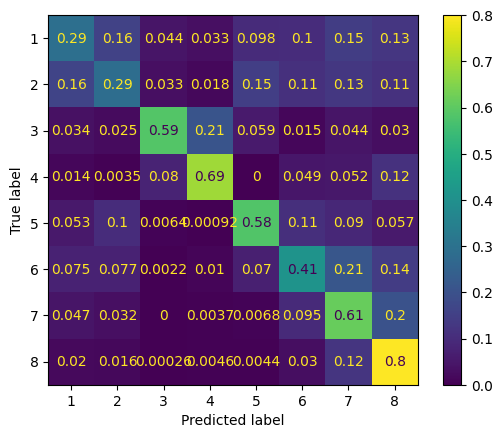

In [29]:
hgb_pred = grid.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, hgb_pred, normalize = 'true', cmap = 'viridis')

<span style="font-size: 20px;">XGBClassifier</span>

<span style="font-size: 17px;">Kappa: 0.573</span>

In [10]:
target = 'Response'
X_train = train.drop(target, axis = 1)
X_validation = validation.drop(target, axis = 1)
X_test = test.drop(target, axis = 1)

y_train = train[target]
y_validation = validation[target]
y_test = test[target]

split_index = [-1]*len(X_train) + [0]*len(X_validation)
ps = PredefinedSplit(test_fold = split_index)

X_train_val = pd.concat((X_train, X_validation))
y_train_val = pd.concat((y_train, y_validation))

In [ ]:
y_train_val = y_train_val.values - np.ones(shape = len(y_train_val), dtype= 'int64') #the model requires that the labels start with 0, so now the classes will be in the range [0,7]
y_test = y_test.values - np.ones(shape = len(y_test), dtype='int64') 

scorer = make_scorer(cohen_kappa_score, weights= 'quadratic')

xgb_results= pd.DataFrame(columns=['Preprocessor','Kappa','Params'])


estimator = XGBClassifier(enable_categorical = True)

param_grid = {'eta' : [0.2, 0.3],
              'subsample': [0.8],
              'max_cat_to_onehot': [30],
              'tree_method': ['hist'],#approx
              'lambda': [10, 20],
              'max_delta_step':[1,5]}

grid = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring= scorer, cv=ps)
grid.fit(X_train_val, y_train_val)
xgb_pred=grid.predict(X_test)
    
  
score = cohen_kappa_score(y_test, xgb_pred, weights= 'quadratic')
xgb_results.loc[len(xgb_results)]= ['none',score,grid.best_params_]
models_results.loc[len(models_results)]= ['XGBClassifier', 'none', estimator, score]

In [12]:
xgb_results.sort_values(by = 'Kappa', ascending= False)

,Preprocessor,Kappa,Params
0,none,0.573,"{'eta': 0.3, 'lambda': 20, 'max_cat_to_onehot': 30, 'max_delta_step': 1, 'subsample': 0.8, 'tree_method': 'hist'}"


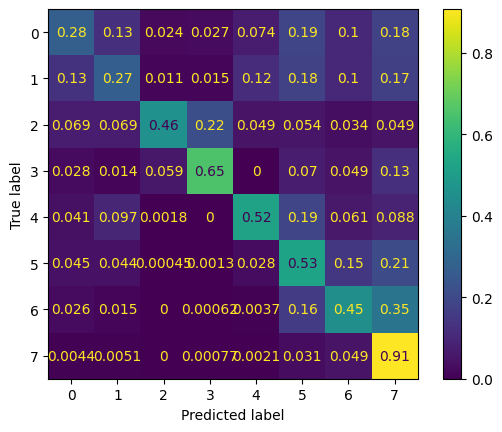

In [33]:
xgb_pred = grid.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, xgb_pred, normalize = 'true', cmap = 'viridis')

The best model is indeed XGBoost, with a quadratic weighted kappa of 0.573. The feature_importances for the model are listed below.

In [34]:
importances = grid.best_estimator_.feature_importances_
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
feature_importance.sort_values('importance', ascending=False).head(20)

,feature,importance
40,Medical_History_4,0.071996
92,Medical_Keyword_15,0.061391
59,Medical_History_23,0.049463
80,Medical_Keyword_3,0.045162
10,BMI,0.036319
51,Medical_History_15,0.033456
76,Medical_History_40,0.025942
66,Medical_History_30,0.020504
3,Product_Info_4,0.020411
41,Medical_History_5,0.018946


<span style="font-size: 25px;">Modeling Results</span>

The best models are the more complex ones, as expected; they are indeed more capable to explain the relationship between the features and the target. Furthermore, applying additional preprocessing steps is not useful in the majority of cases (only LDA gives better results for the KNeighborsClassifier). 

In [36]:
models_results.sort_values(by= 'Kappa',ascending=False)

,Model,Preprocessing steps,Estimator,Kappa
6,XGBClassifier,none,"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=True, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None,\n num_parallel_tree=None, random_state=None, ...)",0.573000
5,HistGradientBoostingClassifier,none,HistGradientBoostingClassifier(categorical_features='from_dtype'),0.563959
4,MLPClassifier,"(ColumnTransformer(transformers=[('continuous',\n Pipeline(steps=[('imputer', SimpleImputer()),\n ('scaler',\n PowerTransformer())]),\n ['Product_Info_4', 'Ins_Age', 'Ht', 'Wt',\n 'BMI', 'Employment_Info_1',\n 'Employment_Info_4', 'Employment_Info_6',\n 'Insurance_History_5', 'Family_Hist_2',\n 'Family_Hist_3', 'Family_Hist_4']),\n ('discrete',\n Pipeline(steps=[('imputer',\n SimpleImputer...\n 'Insurance_History_7', 'Insurance_History_8',\n 'Insurance_History_9', 'Family_Hist_1',\n 'Medical_History_3', 'Medical_History_4',\n 'Medical_History_5', 'Medical_History_6',\n 'Medical_History_7', 'Medical_History_8', ...]),\n ('cat_high_cardinality',\n Pipeline(steps=[('ohe',\n OneHotEncoder(handle_unknown='ignore',\n sparse_output=False)),\n ('reduction',\n SelectKBest(k=20))]),\n ['Medical_History_2'])]), passthrough)","MLPClassifier(batch_size=256, early_stopping=True,\n hidden_layer_sizes=(256, 256), learning_rate='adaptive',\n max_iter=400, n_iter_no_change=30, random_state=2024,\n warm_start=True)",0.533620
3,KNeighborsClassifier,"(ColumnTransformer(transformers=[('continuous',\n Pipeline(steps=[('imputer', SimpleImputer()),\n ('scaler',\n PowerTransformer())]),\n ['Product_Info_4', 'Ins_Age', 'Ht', 'Wt',\n 'BMI', 'Employment_Info_1',\n 'Employment_Info_4', 'Employment_Info_6',\n 'Insurance_History_5', 'Family_Hist_2',\n 'Family_Hist_3', 'Family_Hist_4']),\n ('discrete',\n Pipeline(steps=[('imputer',\n SimpleImputer...\n 'Insurance_History_7', 'Insurance_History_8',\n 'Insurance_History_9', 'Family_Hist_1',\n 'Medical_History_3', 'Medical_History_4',\n 'Medical_History_5', 'Medical_History_6',\n 'Medical_History_7', 'Medical_History_8', ...]),\n ('cat_high_cardinality',\n Pipeline(steps=[('ohe',\n OneHotEncoder(handle_unknown='ignore',\n sparse_output=False)),\n ('reduction',\n SelectKBest(k=20))]),\n ['Medical_History_2'])]), LinearDiscriminantAnalysis())","KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=25, p=1)",0.515597
1,LogisticRegression,"(ColumnTransformer(transformers=[('continuous',\n Pipeline(steps=[('imputer', SimpleImputer()),\n ('scaler',\n PowerTransformer())]),\n ['Product_Info_4', 'Ins_Age', 'Ht', 'Wt',\n 'BMI', 'Employment_Info_1',\n 'Employment_Info_4', 'Employment_Info_6',\n 'Insurance_History_5', 'Family_Hist_2',\n 'Family_Hist_3', 'Family_Hist_4']),\n ('discrete',\n Pipeline(steps=[('imputer',\n SimpleImputer...\n 'Insurance_History_7', 'Insurance_History_8',\n 'Insurance_History_9', 'Family_Hist_1',\n 'Medical_History_3', 'Medical_History_4',\n 'Medical_History_5', 'Medical_History_6',\n 'Medical_History_7', 'Medical_History_8', ...]),\n ('cat_high_cardinality',\n Pipeline(steps=[('ohe',\n OneHotEncoder(handle_unknown='ignore',\n sparse_output=False)),\n ('reduction',\n SelectKBest(k=20))]),\n ['Medical_History_2'])]), passthrough)","LogisticRegression(C=1, class_weight='balanced', n_jobs=-1, solver='newton-cg')",0.505849
2,LinearSVR,"(ColumnTransformer(transformers=[('continuous',\n Pipeline(steps=[('imputer', SimpleImputer()),\n ('scaler',\n PowerTransformer())]),\n ['Product_Info_4', 'Ins_Age', 'Ht', 'Wt',\n 'BMI', 'Employment_Info_1',\n 'Employment_Info_4', 'Employm

The model with the best hyperparameters is then re-fitted for the whole dataset.

In [40]:
best_model = XGBClassifier(enable_categorical = True, eta = 0.3, 
                           reg_lambda= 20, max_cat_to_onehot= 20, 
                           max_delta_step = 1, subsample= 0.8, tree_method= 'hist')

df_w_nan[target] = df_w_nan[target] - np.ones(shape = df_w_nan.shape[0], dtype= 'int64')

best_model.fit(df_w_nan.drop(target, axis=1), df_w_nan[target])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eta=0.3, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=20, max_delta_step=1, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

The model is serialized and saved to be be used in the Prduential_Life_Insurance_Testing notebook. 

In [41]:
file = open("model.save","wb")
pickle.dump(best_model, file)
file.close()